In [5]:
# Required Libraies for the model

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [7]:
#loading and Preprocessing the Data 

train_path = "E:/projects/chest_xray/train"
val_path = "E:/projects/chest_xray/val"
test_path = "E:/projects/chest_xray/test"

train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.2, shear_range=0.2, horizontal_flip=True)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train = train_datagen.flow_from_directory(train_path, target_size=(150, 150), class_mode='binary', batch_size=32)
val = val_test_datagen.flow_from_directory(val_path, target_size=(150, 150), class_mode='binary', batch_size=32)
test = val_test_datagen.flow_from_directory(test_path, target_size=(150, 150), class_mode='binary', batch_size=32)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


class distribution

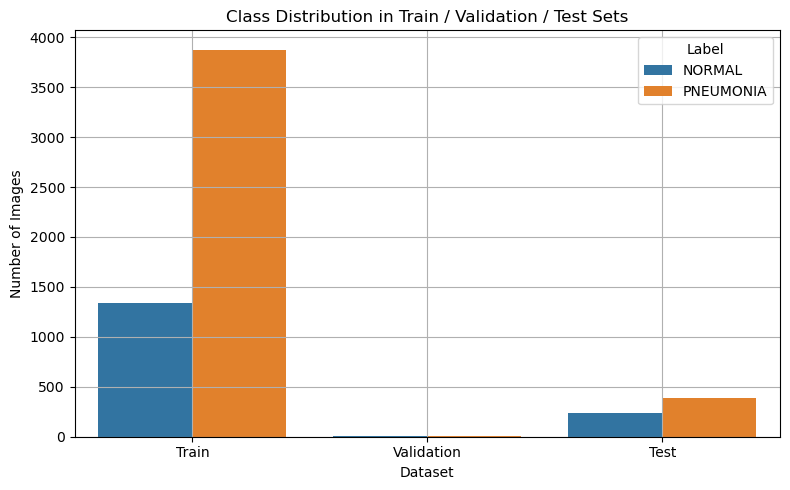

Train class indices: {'NORMAL': 0, 'PNEUMONIA': 1}
Train samples per class: [1341 3875]
Val samples per class: [8 8]
Test samples per class: [234 390]


In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Your dataset paths
train_path = "E:/projects/chest_xray/train"
val_path = "E:/projects/chest_xray/val"
test_path = "E:/projects/chest_xray/test"

labels = ['NORMAL', 'PNEUMONIA']

# Count images in each folder
train_counts = [len(os.listdir(os.path.join(train_path, label))) for label in labels]
val_counts = [len(os.listdir(os.path.join(val_path, label))) for label in labels]
test_counts = [len(os.listdir(os.path.join(test_path, label))) for label in labels]

# Create DataFrame for plotting
df = pd.DataFrame({
    'Label': labels * 3,
    'Count': train_counts + val_counts + test_counts,
    'Dataset': ['Train']*2 + ['Validation']*2 + ['Test']*2
})

# Plotting
plt.figure(figsize=(8, 5))
sns.barplot(x='Dataset', y='Count', hue='Label', data=df)
plt.title("Class Distribution in Train / Validation / Test Sets")
plt.ylabel("Number of Images")
plt.grid(True)
plt.tight_layout()
plt.show()

print("Train class indices:", train.class_indices)
print("Train samples per class:", np.bincount(train.classes))
print("Val samples per class:", np.bincount(val.classes))
print("Test samples per class:", np.bincount(test.classes))

In [15]:
# Calculating class weights based on training set distribution

from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train.classes),
    y=train.classes
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: 1.9448173005219984, 1: 0.6730322580645162}


We calculated class weights to handle the class imbalance in our training data.  
PNEUMONIA images outnumber NORMAL images, which can bias the model.

> **Class weights help the model treat both classes more equally and tell the model to give more importance to the minority class (NORMAL)**

## Dataset Summary

- Train: 1341 NORMAL, 3875 PNEUMONIA  
- Validation: 8 NORMAL, 8 PNEUMONIA  
- Test: 234 NORMAL, 390 PNEUMONIA



In [18]:
#Building the CNN Model

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid') 
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.2, verbose=1)

# Training the model(With WEIGHTS)
history = model.fit(
    train,
    validation_data=val,
    epochs=20,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weights 
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [21]:
#Evaluating the Model

loss, accuracy = model.evaluate(test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

20/20 [==============================] - 11s 558ms/step - loss: 0.2291 - accuracy: 0.9054
Test Loss: 0.2291
Test Accuracy: 0.9054


20/20 [==============================] - 21s 1s/step
Classification Report:

              precision    recall  f1-score   support

      Normal       0.39      0.39      0.39       234
   Pneumonia       0.64      0.64      0.64       390

    accuracy                           0.55       624
   macro avg       0.52      0.51      0.51       624
weighted avg       0.55      0.55      0.55       624



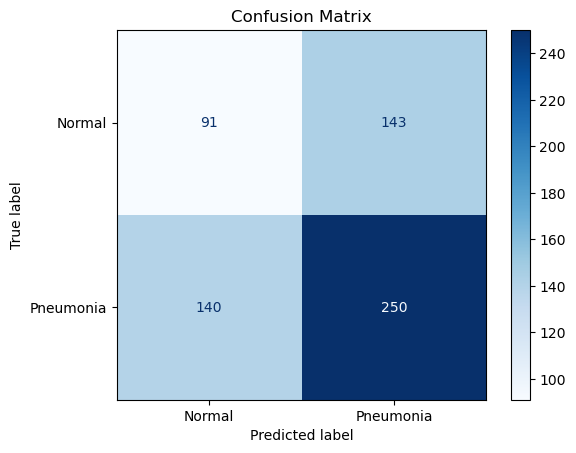

In [41]:
#classification_report, confusion_matrix

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

#labels and predictions
y_true = test.classes
y_pred_probs = model.predict(test)
y_pred = (y_pred_probs > 0.5).astype(int).reshape(-1)

# Classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))

# Confusion Matrix:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Pneumonia'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()


Accuracy & Loss plot

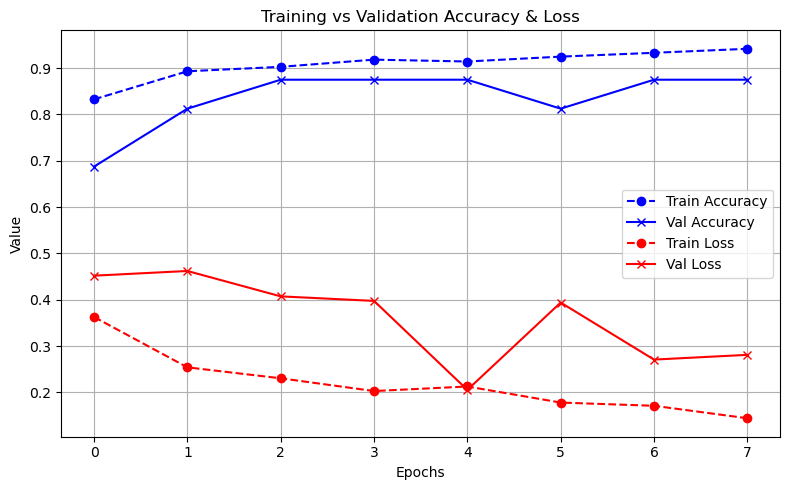

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue', linestyle='--', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='blue', linestyle='-', marker='x')

# Plot loss
plt.plot(history.history['loss'], label='Train Loss', color='red', linestyle='--', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', color='red', linestyle='-', marker='x')

plt.title("Training vs Validation Accuracy & Loss")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


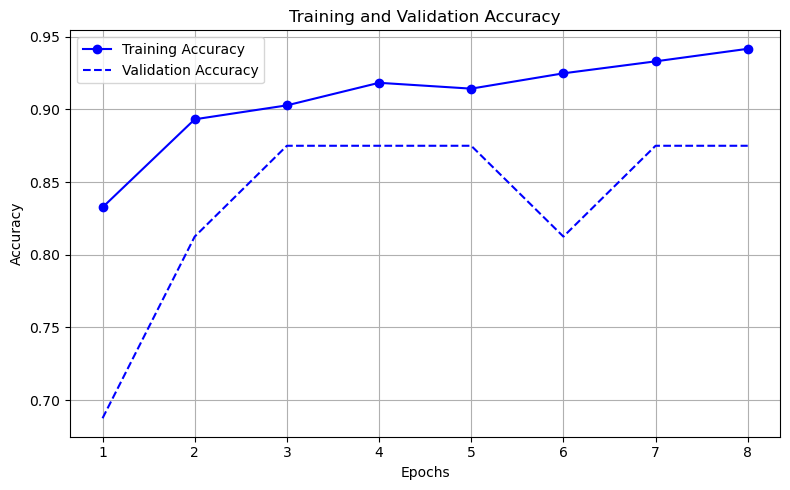

In [27]:
# Accuracy vs Epochs (Training & Validation)

import matplotlib.pyplot as plt

# Extract accuracy data from training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(8, 5))
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b--', label='Validation Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

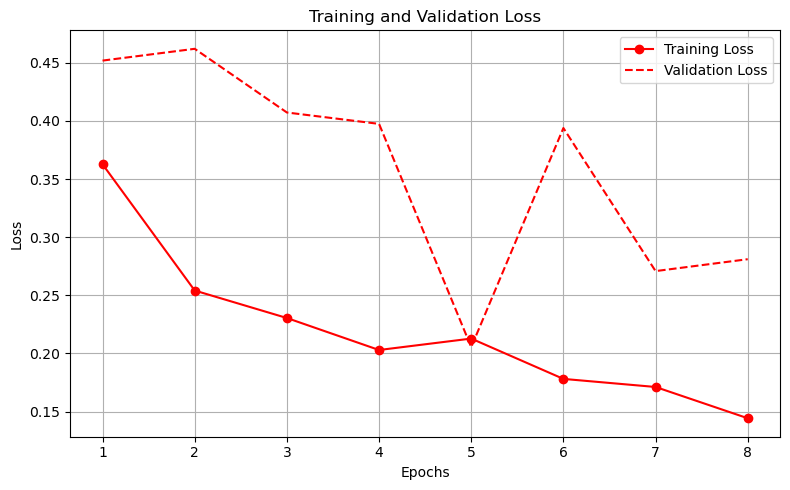

In [29]:
#Loss vs Epochs (Training & Validation)

import matplotlib.pyplot as plt

# Extract loss data from training history
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Plot loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, loss, 'ro-', label='Training Loss')
plt.plot(epochs, val_loss, 'r--', label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [31]:
#Saving the model

model.save("pneumonia_cnn_model.h5")

Testing

In [34]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import numpy as np

# Loading the trained model
model = load_model('pneumonia_cnn_model.h5')

Testing 1

1/1 [==============================] - 0s 228ms/step


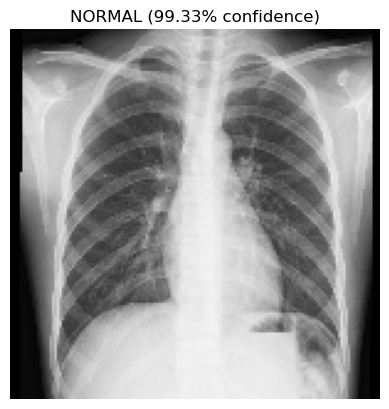

In [37]:
img_path = "E:/projects/test_img.jpeg" 

# Preprocess the image
img = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(img) / 255.0  # Rescaling
img_array = np.expand_dims(img_array, axis=0)  #batch dimension

# Predict with model
prediction = model.predict(img_array)[0][0]  # value between 0 and 1

# Get predicted label and confidence
label = "PNEUMONIA" if prediction >= 0.5 else "NORMAL"
confidence = prediction * 100 if label == "PNEUMONIA" else (1 - prediction) * 100

# Display image with prediction
plt.imshow(img)
plt.axis('off')
plt.title(f"{label} ({confidence:.2f}% confidence)")
plt.show()


Testing 2

1/1 [==============================] - 0s 50ms/step


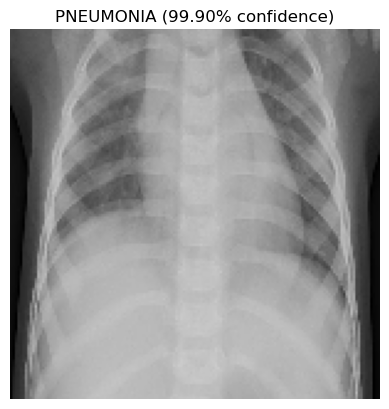

In [39]:
img_path2 = "E:/projects/test_img4.jpeg" 

# Preprocess the image
img = image.load_img(img_path2, target_size=(150, 150))
img_array = image.img_to_array(img) / 255.0  # Rescaling
img_array = np.expand_dims(img_array, axis=0)  #batch dimension

# Predict with model
prediction = model.predict(img_array)[0][0]  # value between 0 and 1

# Get predicted label and confidence
label = "PNEUMONIA" if prediction >= 0.5 else "NORMAL"
confidence = prediction * 100 if label == "PNEUMONIA" else (1 - prediction) * 100

# Display image with prediction
plt.imshow(img)
plt.axis('off')
plt.title(f"{label} ({confidence:.2f}% confidence)")
plt.show()